# Le-Net 1 based architecture

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as lin
import scipy.signal as sig
from PIL import Image
import glob
import matplotlib.cm as cm
import itertools

In [56]:
########### Functions ############################################################################################################################

# Define Activitation functions, pooling and convolution functions (the rules)

def Sigmoid(x): 
    return (1/(1+np.exp(-x)))

def Sigmoid_dx(x):
    return np.exp(-x)/((1+np.exp(-x))**2)

def TanH(x):
    return (1-np.exp(-x))/(1+np.exp(-x))


def Pool(I,W):
    PoolImg=np.zeros((len(I)/len(W),len(I)/len(W))) # W must fit an integer times into I.
    for i in range(0,len(PoolImg)):
        for j in range(0,len(PoolImg)):
            SelAr=I[i*len(W):(i+1)*len(W),j*len(W):(j+1)*len(W)]
            PoolImg[i,j]=np.inner(SelAr.flatten(),W.flatten()) # Now this is just an inner product since we have vectors
    return PoolImg

# To automatically make Gaussian kernels
def makeGaussian(size, fwhm = 3, center=None):
    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]

    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

# To automatically define pooling nodes
def Pool_node(N):
    s=(N,N)
    a=float(N)*float(N)
    return (1.0/a)*np.ones(s) 



In [57]:
#################### Define pooling layers ###########################################################################
P12=Pool_node(4)*(1.0/1.000) #factor 1000 added to lower values more
P34=Pool_node(1)*(1.0/1.0) 

#################### Define Convolution layers #######################################################################

######### First C layer #########
C1=[]
Kernelsize=9
## First Kernel

# Inspiration: http://en.wikipedia.org/wiki/Sobel_operator
# http://stackoverflow.com/questions/9567882/sobel-filter-kernel-of-large-size

## First kernel
Kernel=np.zeros((Kernelsize,Kernelsize))
for i in range(0,Kernelsize):
    for j in range(0,Kernelsize):
        if(i==j):Kernel[i,j]=1
        if(i>j): Kernel[i,j]=5
        if(i<j): Kernel[i,j]=-5
            
C1.append(Kernel*(1.0/100.0))


Kernel=np.array([[4,3,2,1,0,-1,-2,-3,-4],
                 [5,4,3,2,0,-2,-3,-4,-5], 
                 [6,5,4,3,0,-3,-4,-5,-6],
                 [7,6,5,4,0,-4,-5,-6,-7], 
                 [8,7,6,5,0,-5,-6,-7,-8],
                 [7,6,5,4,0,-4,-5,-6,-7],
                 [6,5,4,3,0,-3,-4,-5,-6],
                 [5,4,3,2,0,-2,-3,-4,-5],
                 [4,3,2,1,0,-1,-2,-3,-4]])

C1.append(Kernel*(1.0/100.0))

## Fourth Kernel
Kernel=np.zeros((Kernelsize,Kernelsize))
Kernel[0:4,:]=-5
Kernel[4:5,:]=0
Kernel[5:9,:]=5    
C1.append(Kernel*(1.0/100.0))
        

## kernel
Kernel=np.zeros((Kernelsize,Kernelsize))
Kernel[3:6,3:6]=-2 
Kernel[4,4]=8
C1.append(Kernel*(1.0/100.0))

## kernel
Kernel=np.transpose(C1[2])
C1.append(Kernel)


######### Initialize output weights and biases #########

# Initialisation, since this layer should be trained!
N_branches=1
ClassAmount=3 # Forest, City, Water


import pickle
file=open('W_michiel.txt','r')
W=pickle.load(file)
file=open('C2_michiel.txt','r')
C2=pickle.load(file)
file=open('bias_michiel.txt','r')
bias=pickle.load(file)
file=open('H3_bias_michiel.txt','r')
H3_bias=pickle.load(file)

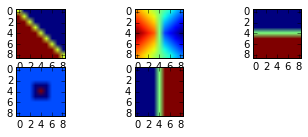

In [58]:
N_plts=len(C1)
for i in range(0,N_plts):
    plt.subplot(4,3,i+1)
    plt.imshow(C1[i])    

In [75]:
####### Test phase on new images #######
Error_Test=[]
N_correct=0
patchSize=40 

name="Test/Test4.png"
img = Image.open(name)
data=img.convert('RGB')
data= np.asarray( data, dtype="int32" )
data=0.2126*data[:,:,0]+0.7152*data[:,:,1]+0.0722*data[:,:,2]
Yamount=data.shape[0]/patchSize # Counts how many times the windowsize fits in the picture
Xamount=data.shape[1]/patchSize # Counts how many times the windowsize fits in the picture
    
    
Patches=np.array([[data[y*patchSize:(y+1)*patchSize,  x*patchSize:(x+1)*patchSize] for x in range(0,Xamount)] for y in range(0,Yamount)]) 



In [76]:
Patches[0,0].shape

(40L, 40L)

In [77]:
from itertools import product
###### Chooses patch and defines label #####
#for PP in range(0,len(Sequence)):
forest=0
city=0
grass=0
cityImg=[]
forestImg=[]

inputPatch=np.zeros((patchSize,patchSize))
Classifier_array=np.zeros((len(Patches[:,0,0,0]),len(Patches[0,:,0,0]),3))
for i in range(0,len(Patches[:,0,0,0])):
    for j in range(0,len(Patches[0,:,0,0])):
        inputPatch=Patches[i,j]
        ### Layer 1 ###
        H1=[]
        H2=[]
        H3=[[np.zeros((4,4)) for b in range(0,N_branches)] for r in range(0,len(C1))]
        H4=[[np.zeros((4,4)) for b in range(0,N_branches)] for r in range(0,len(C1))]
        I_H3=np.ones((4,4))
        x=np.zeros(ClassAmount)
        f=np.zeros(ClassAmount)

        for r in range (0, len(C1)):
            H1.append(sig.convolve(inputPatch, C1[r], 'valid'))
            H2.append(Pool(H1[r], P12))
            for b in range(0,N_branches):
                H3[r][b]=Sigmoid(sig.convolve(H2[r], C2[r][b],'valid')-H3_bias[r][b]*I_H3)
                H4[r][b]=Pool(H3[r][b],P34)

        for k in range(0,ClassAmount):
            for r in range (0, len(C1)):
                for b in range(0,N_branches):
                    x[k]=x[k]+np.inner(H4[r][b].flatten(),W[r][b,k].flatten())
            f[k]=Sigmoid(x[k]-bias[k])

        if(np.argmax(f)==0):
            forest+=1.0
            forestImg.append(inputPatch)
        if(np.argmax(f)==1):
            city+=1.0
            cityImg.append(inputPatch)
        if(np.argmax(f)==2):grass+=1.0     
        Classifier_array[i,j]=f/np.sum((f))


        

In [62]:
Classifier_array[0][0]

array([ 0.44053389,  0.20710428,  0.35236183])

In [78]:
print forest, city, water

353.0 47.0 0


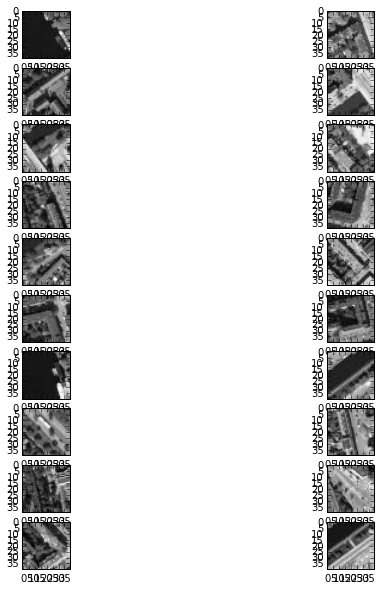

In [74]:
plt.figure(figsize=(10,10))
for i in range(0,20):
    plt.subplot(10,2,i+1)
    plt.imshow(cityImg[i],cmap=cm.Greys_r)